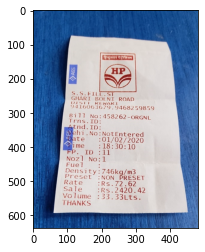

In [2]:
#Step 1: Read the photograph or image

# import required libraries
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
# parameter for image to scan/process
args_image = "bill.png"
# read the image
image = cv2.imread(args_image)
orig = image.copy()
# show the original image
# cv2.imshow("Original Image", image)
# if cv2.waitKey(0) & 0xFF == ord('q'):
#     cv2.destroyAllWindows()
plt.imshow(image)
plt.show()


In [4]:
#Step 2: Identify the edges

# convert image to gray scale. This will remove any color noise
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur the image to remove high frequency noise 
# it helps in finding/detecting contour in gray image
grayImageBlur = cv2.blur(grayImage,(3,3))
# then we performed canny edge detection
edgedImage = cv2.Canny(grayImageBlur, 100, 300, 3)
# show the gray and edge-detected image
# cv2.imshow("gray", grayImage)
# cv2.imshow("grayBlur", grayImageBlur)
# cv2.imshow("Edge Detected Image", edgedImage)
# cv2.waitKey(0) # press 0 to close all cv2 windows
# cv2.destroyAllWindows()

<function matplotlib.pyplot.show(close=None, block=None)>

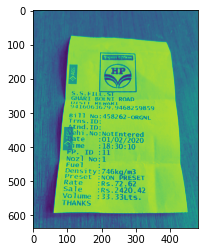

In [6]:
plt.imshow(grayImage)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

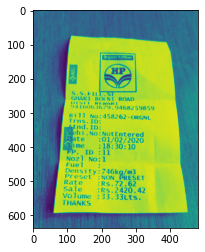

In [8]:
plt.imshow(grayImageBlur)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

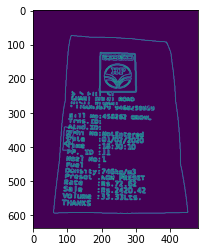

In [10]:
plt.imshow(edgedImage)
plt.show

In [12]:
#Step 3: Detect document edges in the image:

# find the contours in the edged image, sort area wise 
# keeping only the largest ones 
allContours = cv2.findContours(edgedImage.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
allContours = imutils.grab_contours(allContours)
# descending sort contours area and keep top 1
allContours = sorted(allContours, key=cv2.contourArea, reverse=True)[:1]
# approximate the contour
perimeter = cv2.arcLength(allContours[0], True) 
ROIdimensions = cv2.approxPolyDP(allContours[0], 0.02*perimeter, True)
# show the contour on image
cv2.drawContours(image, [ROIdimensions], -1, (0,255,0), 2)
# cv2.imshow("Contour Outline", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

array([[[112, 111, 106],
        [ 85, 104, 128],
        [  9,  67, 137],
        ...,
        [ 29,  90, 154],
        [ 36,  97, 161],
        [ 38,  99, 163]],

       [[112, 110, 106],
        [ 86, 107, 129],
        [ 13,  70, 140],
        ...,
        [ 27,  88, 152],
        [ 33,  94, 158],
        [ 41, 102, 166]],

       [[112, 110, 106],
        [ 86, 107, 129],
        [ 13,  70, 140],
        ...,
        [ 27,  88, 152],
        [ 31,  91, 156],
        [ 39, 100, 164]],

       ...,

       [[117, 114, 113],
        [ 92, 120, 148],
        [ 17,  87, 160],
        ...,
        [ 86, 131, 192],
        [ 82, 127, 188],
        [ 74, 120, 181]],

       [[117, 114, 113],
        [ 93, 121, 148],
        [ 14,  86, 158],
        ...,
        [ 83, 129, 189],
        [ 89, 134, 195],
        [ 80, 126, 188]],

       [[117, 114, 113],
        [ 91, 120, 148],
        [ 13,  85, 157],
        ...,
        [ 83, 128, 189],
        [ 86, 133, 195],
        [ 77, 126, 188]]

<function matplotlib.pyplot.show(close=None, block=None)>

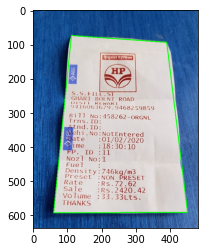

In [14]:
plt.imshow(image)
plt.show

In [16]:
#Step 4: Identify and extract document boundary/edges:

# reshape coordinates array
ROIdimensions = ROIdimensions.reshape(4,2)
# list to hold ROI coordinates
rect = np.zeros((4,2), dtype="float32")
# top left corner will have the smallest sum, 
# bottom right corner will have the largest sum
s = np.sum(ROIdimensions, axis=1)
rect[0] = ROIdimensions[np.argmin(s)]
rect[2] = ROIdimensions[np.argmax(s)]
# top-right will have smallest difference
# botton left will have largest difference
diff = np.diff(ROIdimensions, axis=1)
rect[1] = ROIdimensions[np.argmin(diff)]
rect[3] = ROIdimensions[np.argmax(diff)]
# top-left, top-right, bottom-right, bottom-left
(tl, tr, br, bl) = rect
# compute width of ROI
widthA = np.sqrt((tl[0] - tr[0])**2 + (tl[1] - tr[1])**2 )
widthB = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2 )
maxWidth = max(int(widthA), int(widthB))
# compute height of ROI
heightA = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2 )
heightB = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2 )
maxHeight = max(int(heightA), int(heightB))

In [18]:
#Step 5: Apply perspective transform:

# Set of destinations points for "birds eye view"
# dimension of the new image
dst = np.array([
    [0,0],
    [maxWidth-1, 0],
    [maxWidth-1, maxHeight-1],
    [0, maxHeight-1]], dtype="float32")
# compute the perspective transform matrix and then apply it
transformMatrix = cv2.getPerspectiveTransform(rect, dst)
# transform ROI
scan = cv2.warpPerspective(orig, transformMatrix, (maxWidth, maxHeight))
# lets see the wraped document
# cv2.imshow("Scaned",scan)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

<function matplotlib.pyplot.show(close=None, block=None)>

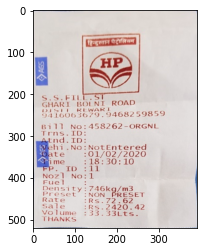

In [20]:
plt.imshow(scan)
plt.show

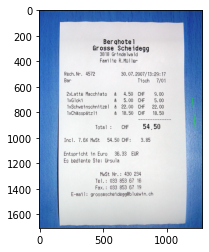

In [6]:
# Step 6 

# convert to gray
scanGray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
# display final gray image
cv2.imshow("scanGray", scanGray)
cv2.waitKey(0)
cv2.destroyAllWindows()
# ------------------------------
# convert to black/white with high contrast for documents
from sickit_image.filters import threshold_local
# increase contrast incase its document
T = threshold_local(scanGray, 9, offset=8, method="gaussian")
scanBW = (scanGray > T).astype("uint8") * 255
# display final high-contrast image
cv2.imshow("scanBW", scanBW)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
plt.imshow(scanBW)
plt.show